# Lab 3: Generating Text with an Autoregressive Model

In this lab, we will build a simple model for generating text in the style of a given book. In lecture, we learned about **probabalistic models**, which views the data given as the result of some random process. In this lab, we will be using this probablistic assumption to **generate new data**. Specifically, we will use an autoregressive model, as discussed in Lecture 4. Our model will begin with a list of words, and generate a new word based on the $k$ most recent previous words. $k$ is chosen to be a small fixed constant, which limits the complexity of the model.

Sometimes this type of model is also called a Markov Model. Similar techniques can be used for time-series and really any other data that has some notion of _recency_. For example, our Lab 2 studied an auto-regressive model for time series data. Even fancy modern language models like the GPT family of models are auto-regressive.

We get our input data from [Project Gutenberg](https://www.gutenberg.org/), a free library of public-works books made available online. By default, we include four books in this lab:
- _Alice in Wonderland_ by Lewis Carroll
- _Metamorphosis_ by Franz Kafka
- _The Count of Monte Cristo_ by Alexandre Dumas
- _The Complete Works of William Shakespeare_ by William Shakespeare

You will be able to add or change these book as you please, and there is code to make this relatively seamless. Pick your favorite work on the site!

---

The goals of this lab are to:
- Get some experience preprocessing data
- Train and generate text with an autoregressive model
- Understand the quality/plagiarism tradeoff that comes with increasing the complexity of the autoregressive model
- Get some experience building experiments that teach us about our models


In [1]:
# Importing Libararies

import random
import numpy as np
from tqdm import tqdm # Quality-of-life package, makes loading bars in for loops. See github.com/tqdm/tqdm for details.

import matplotlib.pyplot as plt
plt.style.use('classic') # Optional styling for the plots. I think it's pretty.

---

# 1. Preprocessing text

First, we have some code to help you download books from Project Gutenberg directly. The function `download_from_book_id(bookid, bookname)` will take the id of a book on Gutenberg and download it locally as the file `bookname.txt`.

However, we will see that the `.txt` files hosted by Project Gutenberg have headers and footer containing some metadata and legal text. Your first coding task will be to remove that metadata and legal text.

To use your own book of interest, search for it on Project Gutenberg, and take the number at the end of the url for that page. For instance, if you search for _The Count of Monte Cristo_, you will get the url `https://www.gutenberg.org/ebooks/1184`, and so the `bookid=1184` for that book.


In [2]:
#Code adapted from https://pypi.org/project/Gutenberg/ to help download from
#Project Gutenberg (www.gutenberg.org/) automatically. You don't need to read this.

def _format_download_urls(etextno):
    """
    Returns the possible urls location on the Project Gutenberg servers for a
    given text. Mostly ripped from https://pypi.org/project/Gutenberg/.
    """
    uri_root = r'http://www.gutenberg.lib.md.us'

    if 0 < etextno < 10:
        oldstyle_files = (
            'when11',
            'bill11',
            'jfk11',
            'getty11',
            'const11',
            'liber11',
            'mayfl11',
            'linc211',
            'linc111',
        )
        etextno = int(etextno)
        return '{root}/etext90/{name}.txt'.format(
            root=uri_root,
            name=oldstyle_files[etextno - 1])

    else:
        etextno = str(etextno)
        extensions = ('.txt', '-8.txt', '-0.txt')
        urls = []
        for extension in extensions:
            uri = '{root}/{path}/{etextno}/{etextno}{extension}'.format(
                root=uri_root,
                path='/'.join(etextno[:len(etextno) - 1]),
                etextno=etextno,
                extension=extension)
            urls.append(uri)
        return urls

In [3]:
def download_from_book_id(bookid, bookname):
  """
  Downloads a from book from Project Gutenberg given the book's id number, and
  stores it locally in `bookname.txt`.

  :param      bookid:    The id of the book on Project Gutenberg
  :type       bookid:    int
  :param      bookname:  The name to give the book (or rather the file path to the book)
  :type       bookname:  str
  """

  book_dst = f'{bookname}.txt'

  import os
  from six.moves import urllib

  if os.path.isfile(book_dst):
      print('File %s is already downloaded' % book_dst)
  else:
      possible_urls = _format_download_urls(bookid)
      print(possible_urls)
      for url in possible_urls:
        print(f'trying {url}...')
        try:
          urllib.request.urlretrieve(url, book_dst)
          print(f'Downloaded {bookname}.txt, with book id {bookid}.')
          return
        except urllib.error.HTTPError:
          None
      raise NameError("Couldn't find that book on Gutenberg")


In [4]:
download_from_book_id(100, "Shakespeare")
download_from_book_id(5200, "Metamorphosis")
download_from_book_id(11, "Wonderland")
download_from_book_id(1184, "MonteCristo")

File Shakespeare.txt is already downloaded
File Metamorphosis.txt is already downloaded
File Wonderland.txt is already downloaded
File MonteCristo.txt is already downloaded


---

Now we have stored `Shakespeare.txt`, `Metamorphosis.txt`, `Wonderland.txt`, and `MonteCristo.txt` locally. Let's open up one of these files and look at the first 1000 characters:

---

In [5]:
file_handle = open("Wonderland.txt", encoding="utf8")  # It's very important to mention utf8 encoding
wonderland_book_text = file_handle.read()  # Copies the book as a string in memory
file_handle.close()

print(wonderland_book_text[0:1000])

﻿*** START OF THE PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN
WONDERLAND ***
[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER III.   A Caucus-Race and a Long Tale
 CHAPTER IV.    The Rabbit Sends in a Little Bill
 CHAPTER V.     Advice from a Caterpillar
 CHAPTER VI.    Pig and Pepper
 CHAPTER VII.   A Mad Tea-Party
 CHAPTER VIII.  The Queen’s Croquet-Ground
 CHAPTER IX.    The Mock Turtle’s Story
 CHAPTER X.     The Lobster Quadrille
 CHAPTER XI.    Who Stole the Tarts?
 CHAPTER XII.   Alice’s Evidence




CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”


---

We can see that most of this is legal exta and metadata we do not want to include in our machine learning model. Conveniantly, Project Gutenberg added the following line of text to each book at the start:
> `*** START OF THE PROJECT GUTENBERG EBOOK`

Similarly, the end of the book has a huge amount of text (about 20,000 characters) that is not actually part of the book. Again, Project Gutenberg has the following line of text to note where the actual book ends:
> `*** END OF THE PROJECT GUTENBERG EBOOK`

Your first task is to write the following function `word_sequence_from_file`. This function is given a filepath to a locally downloaded Project Gutenberg book. It reads that file, finds where the text of the book actually starts and ends (i.e. without metadata and legal text), and returns the text of the book as a list of strings.

You should use the command `str.split()` to turn a string into a list of words. An example is given below.

In [6]:
# An example of string splitting
"This is a string.\n\n\nIt has a new line     and \t lots of whitespace in it. Some punctuation too -- like this!!!".split()

['This',
 'is',
 'a',
 'string.',
 'It',
 'has',
 'a',
 'new',
 'line',
 'and',
 'lots',
 'of',
 'whitespace',
 'in',
 'it.',
 'Some',
 'punctuation',
 'too',
 '--',
 'like',
 'this!!!']

In [7]:
def word_sequence_from_file(filepath):
    """
    Given a filepath to a text file for a Project Gutenberg book, this splits
    the book into a list of strings, where each string is a word from the book.
    Foratting data, like where \n or spaces happen is destroyed by this, but
    punctuation like "word." are preserved.

    :param      filepath:  The filepath to the book
    :type       filepath:  string

    :returns:   A list of strings without any whitespace.
    :rtype:     List of string
    """

    # Open the file
    file_handle = open(filepath, encoding="utf8")
    raw_book_text = file_handle.read()  # Copies the book as a string in memory
    file_handle.close()

    # TODO: Write this function.

    start_of_book = "*** START OF THE PROJECT GUTENBERG EBOOK";
    end_of_book = "*** END OF THE PROJECT GUTENBERG EBOOK"

    start_posi = raw_book_text.find(start_of_book)
    end_posi = raw_book_text.find(end_of_book)

    if start_posi and end_posi:
      book_text = raw_book_text[start_posi + len(start_of_book):end_posi]

    # print (book_text[:500])

    word_sequence = book_text.split()

    return word_sequence

In [8]:

shakespeare = word_sequence_from_file("Shakespeare.txt")
metamorphosis = word_sequence_from_file("Metamorphosis.txt")
wonderland = word_sequence_from_file("Wonderland.txt")
montecristo = word_sequence_from_file("MonteCristo.txt")

To verify that the text looks correct, we can use `" ".join(word_sequence)` to turn a list of strings back into text. Note that we have replaced all whitespace with just a space, so the formatting looks a bit different. The words should be the same though.

In [9]:
# Prints the first 100 words from Kafka's Metamorphosis
# It's okay if there's a couple extra words at the beginning like
# > "by Franz Kafka Translated by David Wyllie"
# This is just a couple words that will not change our model significantly

display(" ".join(metamorphosis[1:100]))

'*** Metamorphosis by Franz Kafka Translated by David Wyllie I One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections. The bedding was hardly able to cover it and seemed ready to slide off any moment. His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked. “What’s happened to me?”'

In [10]:
metamorphosis

['METAMORPHOSIS',
 '***',
 'Metamorphosis',
 'by',
 'Franz',
 'Kafka',
 'Translated',
 'by',
 'David',
 'Wyllie',
 'I',
 'One',
 'morning,',
 'when',
 'Gregor',
 'Samsa',
 'woke',
 'from',
 'troubled',
 'dreams,',
 'he',
 'found',
 'himself',
 'transformed',
 'in',
 'his',
 'bed',
 'into',
 'a',
 'horrible',
 'vermin.',
 'He',
 'lay',
 'on',
 'his',
 'armour-like',
 'back,',
 'and',
 'if',
 'he',
 'lifted',
 'his',
 'head',
 'a',
 'little',
 'he',
 'could',
 'see',
 'his',
 'brown',
 'belly,',
 'slightly',
 'domed',
 'and',
 'divided',
 'by',
 'arches',
 'into',
 'stiff',
 'sections.',
 'The',
 'bedding',
 'was',
 'hardly',
 'able',
 'to',
 'cover',
 'it',
 'and',
 'seemed',
 'ready',
 'to',
 'slide',
 'off',
 'any',
 'moment.',
 'His',
 'many',
 'legs,',
 'pitifully',
 'thin',
 'compared',
 'with',
 'the',
 'size',
 'of',
 'the',
 'rest',
 'of',
 'him,',
 'waved',
 'about',
 'helplessly',
 'as',
 'he',
 'looked.',
 '“What’s',
 'happened',
 'to',
 'me?”',
 'he',
 'thought.',
 'It',
 'w

---

#2. Learning an Autoregressive Model

We will explore a probabilistic model of the English language. We will describe this as a generative model; that is, we describe how book is randomly generated.



We can approximate the structure of a book using a simple model called a **Markov Model** or autoregressive model. A markov model of **order** 0 predicts that each word in the book occurs with a fixed probability, independent of all other words. We can fit such a model to the book by counting the number of occurances of each word in that text, and using these counts as probabilities. For example, we could generate the following sentence from Kafka's _Metamorphosis_:

> and calmness her he way “Gregor! to thought, dark bone fact, in they it than she way as bringing

This obviously misses basic grammar because the model chooses each word independently.
This does not capture how language works, since in reality there are huge correlations between consequtive words. For example, in English, adjectives typically come before nouns -- we say "a red boat" not "a boat red".

We get a more complex model by allowing the probability of choosing each successive word to depend on the preceding words. A **Markov Model of order $k$** predicts that each word occurs with some probability, but that probability depends on the previous $k$ consequtive words, called a **k-gram**.

> For example, suppose a book has the string `My name is` appear 10 times in it. 4 of those times are followed by `Alice`, 2 of those are followed by `Bob`, 2 by `Jesse`, and 2 by `Steve`. Then, a Markov Model of order 3 predicts that the word following the 3-gram `My name is` will be `Alice` with probability $\frac{4}{10}$, `Bob` with probability $\frac{2}{10}$, `Jesse` with probability $\frac{2}{10}$, and `Steve` with probability $\frac{2}{10}$.


---
_This text introduction to Markov Models is a paraphrasing of the [this](https://www.cs.princeton.edu/courses/archive/spr05/cos126/assignments/markov.html) assignment taught at Princeton, originally taught by Bob Sedgewick and Kevin Wayne._

---

Your next task is to write the following function, which, for each k-gram in a book, counts the frequency with which each word appears after that k-gram.

In [11]:
def make_freq_dict(k, word_sequence):
    """
    Makes a "frequency dictionary" called `freq_dict` from a sequence of words.
    For each k-gram that appears in `word_sequence`, freq_dict[k_gram] is
    another dictionary that maps words to how often they occur after k_gram.

    For example, if k=3, suppose that running `freq_dict["they did something"]`
    returns following dictionary:
        {
            "weird": 4,
            "funny": 3,
            "strange.": 7
        }
    Then, the `word_sequence` has the phrase "they did something weird" appear
    4 times, "they did something funny" appear 3 times, and "they did something
    strange." appear 7 times. In other words,
    `freq_dict["they did something"]["strange"]` returns how many times
    "they did something strange" appears in `word_sequence`.

    :param      k:              Size of k-gram
    :type       k:              int
    :param      word_sequence:  A book, broken up into a list of strings
    :type       word_sequence:  List of string

    :returns:   Frequency dictionary
    :rtype:     Dict that maps strings to {Dict that maps string to ints}
    """

    # Make empty dict to count frequencies
    freq_dict = dict()
    ## TODO: WRITE THIS CODE


    # c = 0

    for i in range (len(word_sequence) - k ):
      k_gram = " ".join(word_sequence[i:i+k])

      next_word = word_sequence[i+k]

      if k_gram not in freq_dict:
        freq_dict[k_gram] = {}

      if next_word in freq_dict[k_gram]:
        freq_dict[k_gram][next_word] += 1
      else:
        freq_dict[k_gram][next_word] = 1

    return freq_dict

In [12]:
abc = make_freq_dict(3, shakespeare)

In [13]:
abc

{'THE COMPLETE WORKS': {'OF': 1},
 'COMPLETE WORKS OF': {'WILLIAM': 1},
 'WORKS OF WILLIAM': {'SHAKESPEARE': 1},
 'OF WILLIAM SHAKESPEARE': {'***': 1},
 'WILLIAM SHAKESPEARE ***': {'\ufeffThe': 1},
 'SHAKESPEARE *** \ufeffThe': {'Complete': 1},
 '*** \ufeffThe Complete': {'Works': 1},
 '\ufeffThe Complete Works': {'of': 1},
 'Complete Works of': {'William': 1},
 'Works of William': {'Shakespeare': 1},
 'of William Shakespeare': {'by': 1},
 'William Shakespeare by': {'William': 1},
 'Shakespeare by William': {'Shakespeare': 1},
 'by William Shakespeare': {'Contents': 1},
 'William Shakespeare Contents': {'THE': 1},
 'Shakespeare Contents THE': {'SONNETS': 1},
 'Contents THE SONNETS': {'ALL’S': 1},
 'THE SONNETS ALL’S': {'WELL': 1},
 'SONNETS ALL’S WELL': {'THAT': 1},
 'ALL’S WELL THAT': {'ENDS': 2},
 'WELL THAT ENDS': {'WELL': 2},
 'THAT ENDS WELL': {'THE': 1, 'Contents': 1},
 'ENDS WELL THE': {'TRAGEDY': 1},
 'WELL THE TRAGEDY': {'OF': 1},
 'THE TRAGEDY OF': {'ANTONY': 2,
  'CORIOLANUS

---

Next, write the following functions that use a `freq_dict` to predict the next words given a $k$-gram, and to generate a whole paragraph given a starting $k$-gram. Be sure to carefully read the descriptions of the functions.

In [14]:
len(abc)

853634

In [15]:
abc_x = make_freq_dict(3, shakespeare[:1000])
len(abc_x)

963

In [16]:
def predict_next_word(this_kgram, freq_dict):
    """
    Randomly picks the next work given the previous k-gram, using the frequency
    of possible next works according to `freq_dict`. If `freq_dict` does not
    contain the k-gram, return None.

    :param      this_kgram:  The current k-gram
    :type       this_kgram:  string
    :param      freq_dict:   A frequency dictionary
    :type       freq_dict:   Dict that maps strings to {Dict that maps string to ints}

    :returns:   The next word, or None
    :rtype:     string or None

    """

    if this_kgram in freq_dict:
      words = list(freq_dict[this_kgram].keys())
      frequencies = list(freq_dict[this_kgram].values())
      next_word = random.choices(words, weights=frequencies, k=1)[0]
      # print(type(next_word))
      return next_word
    else:
      return None

    ## TODO: WRITE THIS FUNCTION
    ## random.choices() will be useful here


def predict_paragraph(start_kgram, k, freq_dict, gen_length=300):
    """
    Given a starting k-gram, this randomly generates `gen_length` many new
    words to form a paragraph of text consistent with `freq_dict`. If the last
    word in the book is generated (i.e. if `predict_next_word` returns None),
    then this will short-circuit and stop generating words early.

    :param      start_kgram:  The kgram to start from.
    :type       start_kgram:  List of string
    :param      k:            k-gram size
    :type       k:            int
    :param      freq_dict:    A frequency dictionary
    :type       freq_dict:    Dict that maps strings to {Dict that maps string to ints}
    :param      gen_length:   The number of words to generate.
    :type       gen_length:   int

    :returns:   A generated paragraph
    :rtype:     List of string
    """

    ## TODO: WRITE THIS FUNCTION

    para = start_kgram.copy()

    # current_kgram = list(start_kgram)
    current_kgram = " ".join(start_kgram)

    # para.append(current_kgram)
    # print (current_kgram)
    # print(current_kgram)
    # print(type(current_kgram))

    for _ in range (gen_length):
      word = predict_next_word(current_kgram, freq_dict)
      # print(f"{current_kgram} --> {word}")
      # print(type(word))
      # print(f"1. {current_kgram}")

      if word is None:
        break
      para.append(word)
      current_kgram = " ".join(para[-k:])

      # # print(f"2. {current_kgram}")
      # print(type(current_kgram))



    return para

In [17]:
# abc

In [18]:
a = predict_paragraph(start_kgram=["to", "the", "very"],k = 3, freq_dict=abc)
" ".join(a)

'to the very quality of my lord. I dance attendance here. I think the policy of that purpose made more in the soldier is flat blasphemy. LUCIO. Art advised o’ that? More on’t. ANGELO. Why do you stay so long, my lords of France? Yond island carrions, desperate of their bones, Ill-favouredly become the morning field. Their ragged curtains poorly are let loose, And our air shakes them passing scornfully. Big Mars seems bankrupt in their beggar’d host, And faintly through a rusty beaver peeps; The horsemen sit like fixed candlesticks With torch-staves in their hand; and their poor jades Lob down their heads, drooping the hides and hips, The gum down-roping from their pale-dead eyes, And in their ship I am sure he is the bridle of your will. ADRIANA. There’s none but asses will be bridled so. LUCIANA. Why, headstrong liberty is lash’d with woe. There’s nothing situate under heaven’s eye But hath his bound in earth, in heaven, or somewhere else, So that perforce you must needs play Pyramus.

In [19]:
b = predict_paragraph(start_kgram=["sadly?", "Sweets", "with"],k = 3, freq_dict=abc)
" ".join(b)

'sadly? Sweets with sweets war not, joy delights in joy: Why lov’st thou that which thou hast here deprived. If in the world so well as Lucentio. TRANIO. O despiteful love! unconstant womankind! I tell thee, Ned, thou hast lost the breed of noble bloods! When went there by an age since the great flood, But it was a torment To lay upon the damn’d, which Sycorax Could not again undo; it was mine art, When I arriv’d and heard thee, that made gape The pine, and let thee out. ARIEL. I thank thee, Arcite, Thou art yet a fair foe, and I feel soft things: Upon my life, my troth, I care not. Yet art thou slain in him. Thou art a soldier, therefore seldom rich. It comes in charity to thee, for all thy living Is ’mongst the dead, and all the world must be peopled. When I said a mother, Methought you saw a serpent. What’s in mother, That you start at it? I say I would be King. BUCKINGHAM. Why, so you are, my thoughts cannot transpose. Angels are bright still, though the brightest fell: Though all 

With these functions, we can run some sample code and see how well our synthetic text generator works! Mess around with the value of `k_test` below to see how changing the size of the $k$-gram impacts the quality of the generated  text. You can also swap out the book from _Metamorphosis_ to any other book you prefer. Lastly, you can change what the starting $k$-gram is by changing `start_test` to some other $k$-gram that appears in your book.

- When you are done, leave this at `k_test=3` and move onto the next section.



In [57]:
# Pick k and make a frequency dictionary from Metamorphosis.
k_test = 3
freq_dict_test = make_freq_dict(k_test, metamorphosis)

# pick a random starting k-gram from the freq-dict.
# start_test = random.choice(list(freq_dict_test.keys())).split()

# Alternatively, pick the start of the book as the first k-gram
# posi = 69
# start_test = metamorphosis[posi:posi + k_test]

start_test = ["had", "no", "intention"]
print (start_test)


# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph)

['had', 'no', 'intention']


'had no intention of frightening anyone, least of all his sister. All he had done his homework as a business trainee, at high school, even while he had been half asleep, and he hurried back under the couch. But he needed great self-control to stay there even for the short time that his sister was in the room, as eating so much food had rounded out his body a little and he could only hear their feet as they stepped heavily on the floor. “Father, Mother”, said his sister, obviously leading her in by the hand. The old chest of drawers was too heavy for a pair of feeble women to be heaving about, but Gregor listened as they pushed it from its place, his sister always taking on the heaviest part of the work for herself and could have known it even without checking. “That’s what I said”, replied the cleaner, and to prove it she gave Gregor’s body another shove with the broom, indifferent as to whether it had been eaten or—more often than not—had been left totally untouched. She still cleared

In [21]:
# freq_dict_test[[:1000]]

---

#3. Creativive or Copying?

This has effectively generated a nice paragraph of text that really feels in the style of Kafka/Shakespeare/etc. It is writing whole sentences that usually feel like valid English. While it is not writing fully coherent paragraphs, it is nevertheless pretty effective. But we quickly run into a common issue with generative models: is this $k$-gram model creating new sentences, or is it just copying whole passages from the original text? For instance, all $k$-grams in our generated text must exist in the original book.

We approach this question with a very simple metric to check for plagiarism: the **Longest Common Substring** (LCS). Below, we use the `LcsFinder` class to do two things:
1. We compute the length of the longest common substring between the full book and our generated paragraph.
1. We visualize long common substrings using a simple approach: starting from the first word of the generated paragraph, we color all of the following words that appear in that same order in the original text in one color. We switch colors everytime the generated text deviates from the original text.

## 3.0 Code we give to you

This is the class `LcsFinder`. Construct it with `LcsFinder(word_sequence)`, where `word_sequence` is a long list of strings (i.e. a book). Once constructed, there's two functions you might want to use:
1. `LcsFinder.lcs_length(small_sequence)`, which finds the length of the Longest Common Substring (LCS) of `small_sequence` and `word_sequence`. `small_sequence` should also be a list of strings.
2. `LcsFinder.greedy_lcs_markdown(small_sequence)`, which takes `small_sequence` and uses Markdown to highlight substrings of that text, where each substring of `small_sequence` is also a substring of `word_sequence`. It uses a greedy strategy to heuristically make these substrings as long as possible.

You don't need to understand how the code in section 3.0 works, but you should understand how to use it. The first code block below is the actual code implimentation, and the two code blocks after that show how to run the code.

_You can expand the code blocks by clocking on <font color="blue">Show code</font>, and can hide the code again with the `Show/hide code` menu in *the* command pallate, which you can open with the key command `cmd-shift-p`._

In [22]:
#The code that impliments `LcsFinder`

from IPython.display import display, Markdown #

# Colors to use in the Markdown Text
md_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#920000", "#DB6D00"]

def list_of_seqs_to_markdown(list_of_sequences):
    """
    Takes in a list-of-list-of-strings, and colors each sublist with a single
    color cycling through the list `md_colors` to pick those colors

    :param      list_of_sequences:  List of list of words
    :type       list_of_sequences:  List of list of words
    """

    # The output string
    display_string = ""
    for i, word_sequence in enumerate(list_of_sequences):
        display_string = display_string + f'<font color={md_colors[i % len(md_colors)]}>{" ".join(word_sequence)}</font> '

    # Draw that string with Markdown
    display(Markdown(display_string))


class LcsFinder:
    """
    Internally, this class takes `word_sequence` and
    builds a hash table from any k-gram that appears in
    `word_sequence` to the list of all indices where that
    k-gram appears in `word_sequence`. This makes finding
    the LCS pretty fast.
    It also stores a set of all less-than-k grams that appear
    in the text, but just as a set and not as a hash table.
    """

    def __init__(self, word_sequence, k=3):
        """
        By default, this hash table uses 3-grams, this seems to work well. Feel
        free to pass in a different k-value, though keep in mind this is a
        heuristic speedup, and is unrelated to the k-gram from the language
        model.

        :param      word_sequence:  A book
        :type       word_sequence:  List of strings
        :param      k:              Heuristic k-gram size for efficient lookup
        :type       k:              int
        """
        self.k = k
        self.word_sequence = word_sequence
        self.index_hash = dict()
        self.short_gram_set = set()

        for i in range(len(word_sequence)-k):

            k_gram = " ".join(word_sequence[i:i+k])  # Build this k-gram
            if k_gram not in self.index_hash:
                self.index_hash[k_gram] = []  # Add it to the hash table if it ain't there
            self.index_hash[k_gram].append(i)  # And add the index to the list

            # Update the set of short grams with all possible grams starting at i, and with length < k.
            self.short_gram_set.update({" ".join(word_sequence[i:i+j]) for j in range(1,k)})

    def length_of_lcs_from_start(self, small_sequence, start_idx):
        """
        Look for the longest common substring of word_sequence and
        small_sequence, subject to the substring starting at
        `small_sequence[start_idx]`. Returns the length of this LCS, measured in
        words.

        :param      small_sequence:  A small word sequence
        :type       small_sequence:  List of strings
        :param      start_idx:       The index where the LCS has to start at
        :type       start_idx:       int

        :returns:   Length of the LCS, measure in words
        :rtype:     int
        """

        # Build the k-gram rooted at start_idx
        start_k_gram = " ".join(small_sequence[start_idx:start_idx+self.k])

        # If the k-gram is in the big hash table,
        if start_k_gram in self.index_hash:

            longest = 0

            # Scan over all indices in the list in the hash table
            for word_seq_index in self.index_hash[start_k_gram]:

                # While loop, starting at size k, expanding the length of the LCS until the sequences stop matching
                i = self.k
                while (word_seq_index + i < len(self.word_sequence) and # in-bounds on word_sequence
                       start_idx + i < len(small_sequence) and # in-bounds on small_sequence
                       self.word_sequence[word_seq_index + i] == small_sequence[start_idx + i]): # the words are the same
                    i = i+1

                # The length of the longest LCS seen so far is kept
                longest = max(longest, i)
            return longest
        else:
            # If the k-gram ain't in the big hash table, check if it's sub-grams are in the stored set
            for i in range(self.k-1,0,-1): # In order from k-1 to 1
                if " ".join(small_sequence[start_idx:start_idx+i]) in self.short_gram_set:
                    return i
            return 0

    def lcs_length(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this returns the length of
        the longest common substring between `small_sequence` and
        `word_sequence`

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Length of the LCS, measured in words
        :rtype:     int
        """
        longest = 0

        # Just iterative over all starting words in `small_sequence` and keep the biggest number
        for i in range(len(small_sequence)):
            sequence_len = self.length_of_lcs_from_start(small_sequence, i)
            longest = max(longest, sequence_len)

        return longest

    # Given `small_sequence`, a list of strings, this prints highlighted markdown that shows where one substring of `word_sequence` ends and the next one starts. If a word doesn't appear in `word_sequence`, we just treat it like a substring of length 1.

    def greedy_lcs_markdown(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this prints highlighted
        markdown that shows where one substring of `word_sequence` ends and the
        next one starts. If a word doesn't appear in `word_sequence`, we just
        treat it like a substring of length 1.

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Markdown display text (renders by default on Jupyter)
        :rtype:     Markdown display text
        """
        list_of_sequences = []  # The output list

        i = 0
        while i < len(small_sequence):
            # iteratate over small_sequence, finding the lcs rooted at index i,
            # and color that LCS accordingly.
            sequence_len = max(self.length_of_lcs_from_start(small_sequence, i), 1)
            list_of_sequences.append(small_sequence[i:i+sequence_len])
            i = i + sequence_len

        return list_of_seqs_to_markdown(list_of_sequences)


In [23]:
#@markdown An example of how to build an `LcsFinder`. The `str.split()` function turns the string into a list of string.
test_word_sequence = "wow this is a sentence that I wrote like wow this is a real thing".split(" ")
test_small_sequence = "heck this is a sentence that is sgetti".split(" ")

test_LCS_finder = LcsFinder(test_word_sequence)
test_lcs_length = test_LCS_finder.lcs_length(test_small_sequence)
display(Markdown(f'The length of the LCS between `test_word_sequence` and `test_small_sequence` is {test_lcs_length}.'))

The length of the LCS between `test_word_sequence` and `test_small_sequence` is 5.

In [24]:
#@markdown An example of coloring the `small_sequence` by all the LCS's found in the word_sequence.
test_LCS_finder.greedy_lcs_markdown(test_small_sequence)

<font color=#009292>heck</font> <font color=#FF6DB6>this is a sentence that</font> <font color=#490092>is</font> <font color=#006DDB>sgetti</font> 

## 3.1 LCS on Generated Text





In [25]:
# metamorphosis[:1000]

gen_paragraph

['seemed',
 'ready',
 'to',
 'slide',
 'off',
 'any',
 'moment.',
 'His',
 'many',
 'legs,',
 'pitifully',
 'thin',
 'compared',
 'with',
 'the',
 'size',
 'of',
 'the',
 'soles',
 'of',
 'his',
 'boots,',
 'but',
 'wasted',
 'no',
 'time',
 'with',
 'that—he',
 'knew',
 'full',
 'well,',
 'right',
 'from',
 'the',
 'first',
 'day',
 'of',
 'his',
 'new',
 'life,',
 'that',
 'his',
 'father',
 'thought',
 'it',
 'necessary',
 'to',
 'always',
 'be',
 'extremely',
 'strict',
 'with',
 'him.',
 'And',
 'so',
 'he',
 'set',
 'himself',
 'to',
 'the',
 'task',
 'of',
 'turning',
 'the',
 'key',
 'in',
 'the',
 'lock',
 'she',
 'said',
 'loudly',
 'to',
 'her',
 'parents',
 '“At',
 'last!”.',
 '“What',
 'now,',
 'then?”,',
 'Gregor',
 'asked',
 'himself',
 'as',
 'he',
 'looked',
 'round',
 'in',
 'amazement',
 'for',
 'their',
 'breakfasts;',
 'they',
 'had',
 'been',
 'forgotten',
 'about.',
 '“Where',
 'is',
 'our',
 'breakfast?”,',
 'the',
 'middle',
 'gentleman',
 'asked',
 'the',
 'cl

In [26]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(gen_paragraph)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(gen_paragraph)

LCS length: 81 words


<font color=#009292>seemed ready to slide off any moment. His many legs, pitifully thin compared with the size of the</font> <font color=#FF6DB6>soles of his boots, but wasted no time with that—he knew full well, right from the first day of his new life, that his father thought it necessary to always be extremely strict with him. And so he</font> <font color=#490092>set himself to the task of turning the key in the lock</font> <font color=#006DDB>she said loudly to her parents “At last!”. “What now, then?”, Gregor asked himself as he looked round in</font> <font color=#B66DFF>amazement for their breakfasts; they had been forgotten about. “Where is our breakfast?”, the middle gentleman asked the cleaner irritably. She just put her finger on her lips and made a quick and silent sign to the men that they might like to come into Gregor’s room. They did so, and stood around Gregor’s corpse with their hands in the pockets of their well-worn coats. It was now quite light in the room. Then the door of the</font> <font color=#920000>hallway where they stood pressed against each other. Someone must have heard them in the kitchen, as Gregor’s father called out: “Is the playing perhaps unpleasant for the gentlemen? We can stop it straight away.” “On the contrary”, said the middle gentleman, “would the young lady not like to come</font> <font color=#DB6D00>into Gregor’s room any more until morning; that gave him plenty of time to think undisturbed about how he would have</font> <font color=#009292>seen long ago that it’s not</font> <font color=#FF6DB6>the time of year to do especially good business, we recognise that; but there simply is no time of year to do</font> <font color=#490092>especially good business, we recognise that; but there simply is no time of year to do no business at all, Mr. Samsa, we cannot allow there to be.” “But Sir”, called Gregor, beside himself and forgetting all else in</font> 

---
Note that in the paragraph above, every chunk of text in the same color was copied directly from the original book.
This shows a non-trivial amount of copying going on. Despite only using $3$-grams, we are often copying much more than 3 words at a time from the original book. Sometimes, we are copying whole sentences.

We find ourselves at an impass:
- If we make $k$ too small, then we lose the structure of grammer, and generate nonsense.
- If we make $k$ too large, then we start plagiarizing.

Let's try to understand the scale of this problem. Take a book, generate 100 paragraphs of 300 words for each of 5 different values of $k$, and compute the length of the LCS between the book and the generated paragraph. Specifically, compute the $25^{th}$ quartile, median, and $75^{th}$ quartile of the LCS length across the 100 trials.

In [27]:
# Which values of k to generate k-grams for and estimate LCS lengths with
ks_to_plot = [1, 2, 3, 4, 5]

def gen_lcs_statistics(word_sequence):
    """
    Given a word_sequence, this generates 100 paragraphs of length 300
    at each of various choices of k-gram size (see `ks_to_plot`). It then
    returns the median, 25th quartile, and 75th quartile of the LCS's length
    at each value of k.

    More precisely, it should return a dictionary with the following shape:
        {
            "medians": np.array([numbers...]),
            "top_quartiles": np.array([numbers...]),
            "bot_quartiles.": np.array([numbers...])
        }
    Where top_quartiles is for the 75^th quartile, and bot_quartiles is for the 25^th quartile.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string

    :returns:   A dictionary with keys "medians", "top_quartiles",
                "bot_quartiles", and values which are numpy vectors
                with the same length as `ks_to_plot`.
    :rtype:     Dict that maps string to numpy array
    """

    n_trials = 100  # number of trials
    gen_length_test = 300  # number of words to generate

    lcs_lengths = np.zeros((len(ks_to_plot), n_trials))
    LCS_FINDER = LcsFinder(word_sequence)

    ## TODO: WRITE THIS CODE
    ## It will be helpful to use np.quantile and np.median



# gen8 para and store lcs lengths in the lists

    for i, k in enumerate (ks_to_plot):
      freq_dict = make_freq_dict(k, word_sequence)
      for trail in range (n_trials):

        # first generate the para
        # start_kgram = random.choice(list(LCS_FINDER.index_hash.keys())).split()
        start_kgram = random.choice(list(freq_dict.keys())).split()

        gen_para = predict_paragraph(start_kgram, k, freq_dict, gen_length_test)

        # then compute the LCS and store it in the list
        lcs_length = LCS_FINDER.lcs_length(gen_para)
        lcs_lengths[i, trail] = lcs_length


# calculate the quartiles among the list

    lcs_length_medians = np.median(lcs_lengths, axis = 1 )
    lcs_length_tops = np.quantile(lcs_lengths, 0.75, axis = 1 )
    lcs_length_bots = np.quantile(lcs_lengths, 0.25, axis = 1 )


    return {"medians": lcs_length_medians, "top_quartiles": lcs_length_tops, "bot_quartiles": lcs_length_bots}

In [28]:
# For a pretty long text, like shakespeare, this still should not take more than 45 seconds.
gen_lcs_statistics(shakespeare)

{'medians': array([  4.,  13.,  46., 154., 305.]),
 'top_quartiles': array([  5.  ,  15.  ,  57.25, 210.75, 305.  ]),
 'bot_quartiles': array([  4.  ,  12.  ,  39.  , 127.25, 225.  ])}

In [29]:
len(shakespeare)

963467

---
Having generated this data, let's plot how the LCS length depends on $k$.
Write the below function, which should produce an image that looks roughly like the following image:

<img src="https://drive.google.com/uc?id=1J9VlSFelSAwa2r7-jrPLUGKf5mTanFyn"></img>

Slight deviations in the colors, shapes, labels, and other aesthetics are fine, but the same information should be portrayed -- a clear median line with clear $25^{th}$ and $75^{th}$ quartiles. The title should also state what book is being used, and the axes should be labeled.

<!-- the img tag is taken from this gdrive link: https://drive.google.com/file/d/1J9VlSFelSAwa2r7-jrPLUGKf5mTanFyn/view?usp=share_link -->


In [30]:
def plot_lcs_statistics(word_sequence, book_title, lcs_stats):
    """
    Given a book, it's title, and the LCS statistics generated by
    `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string
    :param      book_title:     The book's title
    :type       book_title:     String
    :param      lcs_stats:      The lcs statistics
    :type       lcs_stats:      Dict that maps string to numpy array
    """


    ## TODO: WRITE THIS CODE

    ## Use plot() to render the median as one line

    ## Use fill_between() to shade the area 25th and 75th quartiles with a low alpha value, like alpha=0.35

    medians = lcs_stats['medians']
    top_quartiles = lcs_stats['top_quartiles']
    bot_quartiles = lcs_stats['bot_quartiles']



    # ks = np.arange(1, len(lcs_stats['medians']) + 1)


    # median
    plt.plot(ks_to_plot, medians, label='Median', color='blue')

    # Fill between 25ht and 75th quartiles
    plt.fill_between(ks_to_plot, bot_quartiles, top_quartiles, color='blue', alpha=0.35)

    # Add labels and title
    plt.xlabel('k')
    plt.ylabel('LCS Length in words')
    plt.title(f'{book_title}: k versus length of LCS')
    plt.tight_layout()
    plt.show()


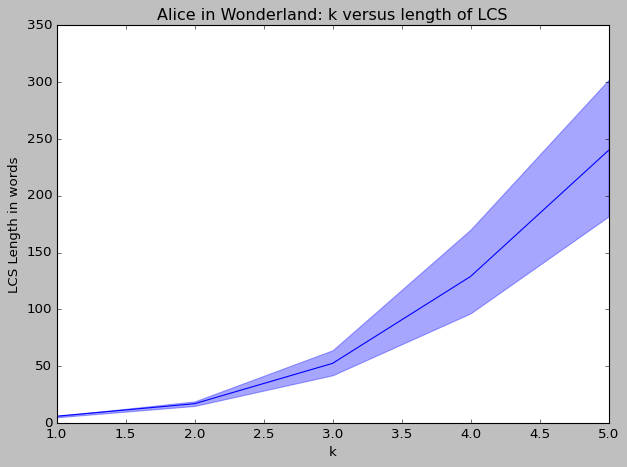

In [31]:
plot_lcs_statistics(wonderland, "Alice in Wonderland", gen_lcs_statistics(wonderland))

Okay, wow. That grows really fast. Exponentially even$\phantom{}^{\dagger}$. This means that, at least for the relatively small amount of training data we used, we get a poor tradeoff between quality (large $k$) and creativity (small $k$).

Maybe we were just unlucky with our choice of book?
Write the next function, which plots LCS lengths for many books all at once.
It should produce and output roughly like the following:

<img src="https://drive.google.com/uc?id=1JJrx3K5I_9qdE8ozTEr2lfyD1eLVu4oU"></img>

Again, slight deviations aesthetics are fine, but the same information should be portrayed.

<!-- the img tag is taken from this gdrive link: https://drive.google.com/file/d/1JJrx3K5I_9qdE8ozTEr2lfyD1eLVu4oU/view?usp=share_link -->


---

$\phantom{}^{[\dagger]}$_It's literally exponential. If you're curious, add `plt.yscale("log")` to your plotting code to see this curve become close-to-linear, suggesting this literally grows at the rate $LCS \approx e^{\Theta(k)}$._

In [32]:
plot_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#6DB6FF", "#B6DBFF", "#920000", "#924900", "#DB6D00", "#24FF24", "#FFFF6D"]

def plot_many_lcs_statistics(list_of_dicts):
    """
    Given a list of dicts, each with a book title, and the LCS statistics
    generated by `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    The given dicts have the following shape, with these exact keys:
        {
            "book_name": string,
            "stats": output of plot_lcs_statistics()
        }

    :param      list_of_dicts:  A list of dicts
    :type       list_of_dicts:  List of dict
    """
    fig, ax = plt.subplots()


    # ks = np.arange(1, len(list_of_dicts[0]["stats"]["medians"]))
    ks = np.arange(1, len(list_of_dicts[0]["stats"]["medians"]) + 1)

    for id, book_data in enumerate (list_of_dicts):
      book_name = book_data['book_name']
      stats = book_data["stats"]

      # medians = lcs_stats['medians']
      medians = stats['medians']
      top_quartiles = stats['top_quartiles']
      bot_quartiles = stats['bot_quartiles']

      color = plot_colors[id % len(plot_colors)]

      # median
      plt.plot(ks, medians, label=book_name, color=color)

      # Fill between 25ht and 75th quartiles
      plt.fill_between(ks, bot_quartiles, top_quartiles, color=color, alpha=0.15)

      # # Add labels and title
      # plt.xlabel('k')
      # plt.ylabel('LCS Length in words')
      # plt.title(f'{book_name}: k versus length of LCS')
      # plt.tight_layout()


    ax.set_xlabel('k')
    ax.set_ylabel('LCS Length in words')
    ax.set_title('Comparison of LCS Lengths Across Different Books')
    ax.legend()
    plt.show()





    ## TODO: WRITE THIS CODE
    ## The same basic idea as the last plot, but with many series overlaid. Make alpha=0.15 for the fill to keep the image legible.
    ## Use some subset of the list of colors at the top -- they are a visually nice set of colorblind-safe colors.


In [33]:
shakes_stats = gen_lcs_statistics(shakespeare)
metamorphosis_stats = gen_lcs_statistics(metamorphosis)
wonderland_stats = gen_lcs_statistics(wonderland)
monte_cristo_stats = gen_lcs_statistics(montecristo)

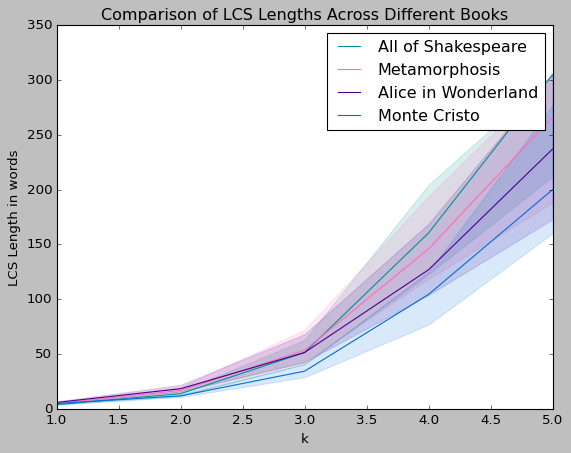

In [34]:
plot_many_lcs_statistics(
    [
        {
            "book_name": "All of Shakespeare",
            "stats": shakes_stats
        },
        {
            "book_name": "Metamorphosis",
            "stats": metamorphosis_stats
        }, {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Monte Cristo",
            "stats": monte_cristo_stats
        }
    ]
)

---

So while some books are a bit better than others, they still all seem to grow at an exponential rate. Improving upon this will with require a better model (we will discuss some later in the course), a lot more training data, or idealy both.

---

# 4.  (Bonus Question -- 2 / 20 points) Can you improve our model?

Code up a modification of our simple $k$-gram model that produces decent text (e.g. better than the 2-gram model) but copies less. To get bonus credit, post a screenshot of your generated text on Ed, using any Project Gutenberg book as the input data. Highlight the text with `LcsFinder` to highlight long common substrings. In your post, add a brief description of how you modified the model.

Think creatively! You are also free to look online for different modifications and technique other people have use, but your lab report should (informally) cite whatever sources you used.


In [35]:
# Write any code used for answering the bonus questions here

In [36]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
random.seed(42)  # You can use any number

nltk.download('stopwords')
nltk.download('wordnet')

def word_sequence_from_file_X(filepath, keep_fraction):
    with open(filepath, encoding="utf8") as file_handle:
        raw_book_text = file_handle.read()

    start_of_book = "*** START OF THE PROJECT GUTENBERG EBOOK"
    end_of_book = "*** END OF THE PROJECT GUTENBERG EBOOK"

    start_posi = raw_book_text.find(start_of_book)
    end_posi = raw_book_text.find(end_of_book)

    if start_posi != -1 and end_posi != -1:
        book_text = raw_book_text[start_posi + len(start_of_book):end_posi]
    else:
        return []

    # Lowercase
    book_text = book_text.lower()

    # # # Remove punctuation
    # translator = str.maketrans('', '', string.punctuation)
    # book_text = book_text.translate(translator)

    # Normalize whitespace
    book_text = ' '.join(book_text.split())

    # Tokenization
    word_sequence = book_text.split()

    # # Remove stop words
    # stop_words = set(stopwords.words('english'))
    # word_sequence = [word for word in word_sequence if word not in stop_words]

    stop_words = set(stopwords.words('english'))
    word_sequence = [word for word in word_sequence if word not in stop_words or (word in stop_words and random.random() < keep_fraction)]


    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    word_sequence = [lemmatizer.lemmatize(word) for word in word_sequence]

    return word_sequence


# def filter_stopwords_with_noise(word_sequence, keep_fraction=0.2):
#     stop_words = set(stopwords.words('english'))
#     result = []
#     for word in word_sequence:
#         if word in stop_words:
#             # Keep a certain fraction of stopwords randomly
#             if random.random() < keep_fraction:
#                 result.append(word)
#         else:
#             result.append(word)
#     return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
metamorphosis = word_sequence_from_file("Metamorphosis.txt")
display(" ".join(metamorphosis[1:100]))

'*** Metamorphosis by Franz Kafka Translated by David Wyllie I One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections. The bedding was hardly able to cover it and seemed ready to slide off any moment. His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked. “What’s happened to me?”'

In [38]:
metamorphosis_X = word_sequence_from_file_X("Metamorphosis.txt", keep_fraction=0.69)
# meta_XX = filter_stopwords_with_noise(metamorphosis_X, keep_fraction=0.5)
display(" ".join(metamorphosis_X[1:100]))

'*** metamorphosis by franz kafka translated by david wyllie i one morning, when gregor samsa woke troubled dreams, he found transformed in his bed into a horrible vermin. he lay on his armour-like back, and if he lifted his head little he could see brown belly, slightly domed divided by arch into stiff sections. bedding wa hardly able to cover it seemed ready to slide moment. his many legs, pitifully thin compared the size of rest of him, waved helplessly a looked. “what’s happened to me?” he thought. it wasn’t a dream. his room, a proper human room although'

In [39]:
# metamorphosis

In [40]:
# metamorphosis_X

In [41]:
from collections import Counter

def preprocess_text_data(word_sequence, n_grams=3):
    """
    Preprocess the text data: build vocabulary, convert text to sequences,
    and create input-output pairs with Laplace smoothing.

    :param word_sequence: List of words from the preprocessed text
    :param n_grams: The number of words in each input sequence
    :return: Vocabulary mapping, reverse mapping, sequences,
             input-output pairs, and n-gram counts
    """

    # Step 1: Build Vocabulary
    word_counts = Counter(word_sequence)
    vocab = {word: i for i, (word, _) in enumerate(word_counts.items())}
    ix_to_word = {i: word for word, i in vocab.items()}
    vocab_size = len(vocab)

    # Step 2: Convert Text to Sequences
    sequences = [vocab[word] for word in word_sequence if word in vocab]

    # Step 3: Create Input-Output Pairs and Count n-grams
    input_output_pairs = []
    ngram_counts = Counter()

    for i in range(len(sequences) - n_grams):
        input_seq = tuple(sequences[i:i + n_grams])
        target_word = sequences[i + n_grams]
        input_output_pairs.append((input_seq, target_word))
        ngram_counts[input_seq] += 1  # Count occurrences of each n-gram

    return vocab, ix_to_word, sequences, input_output_pairs, ngram_counts, vocab_size

def calculate_probability(target_word, input_seq, ngram_counts, vocab_size):
    """
    Calculate the probability of the target word given the input sequence using Laplace smoothing.

    :param target_word: The target word index
    :param input_seq: The input sequence (tuple of indices)
    :param ngram_counts: Count of n-grams
    :param vocab_size: Size of the vocabulary
    :return: Probability of the target word
    """
    ngram_count = ngram_counts[input_seq] if input_seq in ngram_counts else 0
    total_count = sum(ngram_counts.values())  # Total n-gram count

    # Laplace smoothing
    probability = (ngram_count + 1) / (total_count + vocab_size)
    return probability

In [42]:
# Sample usage
metamorphosis_X = word_sequence_from_file_X("Metamorphosis.txt", keep_fraction=0.69)

# Preprocess the text data
vocab, ix_to_word, sequences, input_output_pairs, ngram_counts, vocab_size = preprocess_text_data(metamorphosis_X, n_grams=3)

# Example of calculating the probability
input_seq_example = (sequences[0], sequences[1], sequences[2])  # Example input sequence
target_word_example = sequences[3]  # Example target word
probability_example = calculate_probability(target_word_example, input_seq_example, ngram_counts, vocab_size)

# Output for verification
print("Vocabulary Size:", vocab_size)
print("Sample Input-Output Pairs:", input_output_pairs[:5])
print(f"Probability of the target word '{ix_to_word[target_word_example]}' given the input sequence {input_seq_example}: {probability_example:.4f}")


Vocabulary Size: 3685
Sample Input-Output Pairs: [((0, 1, 0), 2), ((1, 0, 2), 3), ((0, 2, 3), 4), ((2, 3, 4), 5), ((3, 4, 5), 2)]
Probability of the target word 'by' given the input sequence (0, 1, 0): 0.0001


In [43]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded)
        # Get the output from the last time step
        output = self.fc(output[-1])
        return output

from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, input_output_pairs):
        self.input_output_pairs = input_output_pairs

    def __len__(self):
        return len(self.input_output_pairs)

    def __getitem__(self, idx):
        input_seq, target_word = self.input_output_pairs[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_word, dtype=torch.long)

# Create the dataset and DataLoader
dataset = TextDataset(input_output_pairs)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


def train_model(model, dataloader, criterion, optimizer, n_epochs, device):
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for input_seq, target_word in dataloader:
            input_seq, target_word = input_seq.to(device), target_word.to(device)

            optimizer.zero_grad()
            # Reshape input_seq to (sequence_length, batch_size)
            input_seq = input_seq.transpose(0, 1)  # Change from (batch_size, sequence_length) to (sequence_length, batch_size)
            output = model(input_seq)

            loss = criterion(output, target_word)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch: {epoch + 1}/{n_epochs} | Loss: {epoch_loss / len(dataloader):.4f}')



# Model parameters
INPUT_DIM = len(vocab)  # Vocabulary size
OUTPUT_DIM = len(vocab)  # Same as input for predicting next word
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train_model(model, dataloader, criterion, optimizer, n_epochs=10, device=device)

def predict(model, input_seq, ix_to_word, vocab_size, device):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
        output = model(input_tensor)
        predicted_index = output.argmax(dim=1).item()
        return ix_to_word[predicted_index]

# # Example prediction
# input_seq_example = [vocab['Once'], vocab['upon'], vocab['a']]  # Example input sequence
# predicted_word = predict(model, input_seq_example, ix_to_word, vocab_size, device)
# print(f'Predicted next word: {predicted_word}')


Epoch: 1/10 | Loss: 6.9032
Epoch: 2/10 | Loss: 6.2451
Epoch: 3/10 | Loss: 5.6661
Epoch: 4/10 | Loss: 4.8946
Epoch: 5/10 | Loss: 3.9924
Epoch: 6/10 | Loss: 3.0542
Epoch: 7/10 | Loss: 2.2437
Epoch: 8/10 | Loss: 1.6340
Epoch: 9/10 | Loss: 1.1779
Epoch: 10/10 | Loss: 0.8995


In [44]:
pip install language_tool_python

In [45]:
import random
import torch
import language_tool_python
from tqdm import tqdm

def generate_paragraph(model, vocab, ix_to_word, word_sequence, device, max_length=300, top_k=5, temperature=0.2, check_every=4):
    model.eval()

    # Pick a random start index ensuring there's room for 3 consecutive words
    start_index = random.randint(0, len(word_sequence) - 4)  # -4 to ensure 3 words fit
    start_words = word_sequence[start_index:start_index + 3]  # Get 3 consecutive words
    print(f"Starting k-gram: {start_words}")

    generated_words = list(start_words)
    input_seq = [vocab[word] for word in start_words]

    tool = language_tool_python.LanguageTool('en-US')

    # Use tqdm to track the generation progress
    for i in tqdm(range(max_length), desc="Generating words"):
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        input_tensor = input_tensor.transpose(0, 1)

        with torch.no_grad():
            output = model(input_tensor)

        # Apply temperature
        output = output / temperature
        output_probs = torch.softmax(output, dim=-1)

        # Get top-k predictions
        top_k_values, top_k_indices = torch.topk(output_probs, top_k)

        best_word = None
        best_score = float('-inf')

        # Evaluate top-k predictions
        for index in top_k_indices[0]:
            predicted_word = ix_to_word[index.item()]

            # Check grammar every 'check_every' steps
            if i % check_every == 0:
                potential_text = ' '.join(generated_words + [predicted_word])
                matches = tool.check(potential_text)
                score = -len(matches)
            else:
                score = 0  # Skip grammar checking for this round

            # Update best_word if this option is better
            if score > best_score:
                best_score = score
                best_word = predicted_word

        generated_words.append(best_word)

        # Update input sequence
        input_seq.append(vocab[best_word])
        input_seq = input_seq[1:]  # Keep the last n-gram

    generated_text = ' '.join(generated_words)
    return generated_text

# Example usage
generated_paragraph = generate_paragraph(model, vocab, ix_to_word, metamorphosis_X, device)
print("Generated Paragraph:")
print(generated_paragraph)


Starting k-gram: ['had', 'no', 'intention']


Generating words: 100%|██████████| 300/300 [02:07<00:00,  2.35it/s]

Generated Paragraph:
had no intention of frightening anyone, least of all his sister. he had done begin to turn round he would move deeper “this a little, he wa no longer point running his father decided to bombard him. he had filled his pocket with fruit from the bowl on sideboard and now, without even taking the time for careful aim, action.” can’t it wa sit close together, cheek to cheek; mother would point to gregor’s father and mother paid close attention, one on each side, to the movement her hands. drawn in the playing, gregor had dared come forward a little more slowly them, already walking slowly for his sake; who would place stick carefully and, if he wanted to do gregor even thought he glimpsed look of gratitude one time when he became cleared away so gregor turned backwards again, in copious direction, but it would be necessary to drive him back that they had lost sight any thought for the future. the greatest improvement the time being, of course, would be achieved quite e

In [46]:
# import random
# import torch
# import language_tool_python
# from tqdm import tqdm  # Import tqdm

# def generate_paragraph(model, vocab, ix_to_word, word_sequence, device, max_length=300, top_k=5):
#     model.eval()

#     # Pick a random start index ensuring there's room for 3 consecutive words
#     start_index = random.randint(0, len(word_sequence) - 4)  # -4 to ensure 3 words fit
#     start_words = word_sequence[start_index:start_index + 3]  # Get 3 consecutive words
#     print(f"Starting k-gram: {start_words}")

#     generated_words = list(start_words)

#     # Convert start sequence to indices
#     input_seq = [vocab[word] for word in start_words]



#     # Use tqdm to track the generation progress
#     for _ in tqdm(range(max_length), desc="Generating words"):
#         input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
#         input_tensor = input_tensor.transpose(0, 1)  # Shape: (sequence_length, batch_size)

#         with torch.no_grad():
#             output = model(input_tensor)

#         # Get the top k predictions
#         top_k_values, top_k_indices = torch.topk(output, top_k)

#         best_word = None
#         best_score = float('-inf')

#         # Evaluate each top prediction
#         for index in top_k_indices[0]:
#             predicted_word = ix_to_word[index.item()]

#             # Form the potential generated text
#             potential_text = ' '.join(generated_words + [predicted_word])

#             # Check grammar using language_tool_python
#             tool = language_tool_python.LanguageTool('en-US')
#             matches = tool.check(potential_text)
#             score = -len(matches)  # Lower score for more corrections

#             # Update best_word if this option is better
#             if score > best_score:
#                 best_score = score
#                 best_word = predicted_word

#         # Append the best predicted word to the generated words
#         generated_words.append(best_word)

#         # Update the input sequence: remove the first word and add the new best word
#         input_seq.append(vocab[best_word])
#         input_seq = input_seq[1:]  # Keep the last n-grams

#     # Join the generated words into a single string
#     generated_text = ' '.join(generated_words)

#     return generated_text

# # Example usage
# generated_paragraph = generate_paragraph(model, vocab, ix_to_word, metamorphosis_X, device)
# print("Generated Paragraph:")
# print(generated_paragraph)

In [47]:
generated_paragraph

'had no intention of frightening anyone, least of all his sister. he had done begin to turn round he would move deeper “this a little, he wa no longer point running his father decided to bombard him. he had filled his pocket with fruit from the bowl on sideboard and now, without even taking the time for careful aim, action.” can’t it wa sit close together, cheek to cheek; mother would point to gregor’s father and mother paid close attention, one on each side, to the movement her hands. drawn in the playing, gregor had dared come forward a little more slowly them, already walking slowly for his sake; who would place stick carefully and, if he wanted to do gregor even thought he glimpsed look of gratitude one time when he became cleared away so gregor turned backwards again, in copious direction, but it would be necessary to drive him back that they had lost sight any thought for the future. the greatest improvement the time being, of course, would be achieved quite easily by moving hous

In [48]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)
qq = generated_paragraph.split()
# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(qq)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(qq)

LCS length: 13 words


<font color=#009292>had no intention of frightening anyone, least of all his sister.</font> <font color=#FF6DB6>he had done</font> <font color=#490092>begin to turn round</font> <font color=#006DDB>he would</font> <font color=#B66DFF>move</font> <font color=#920000>deeper</font> <font color=#DB6D00>“this</font> <font color=#009292>a little,</font> <font color=#FF6DB6>he</font> <font color=#490092>wa</font> <font color=#006DDB>no longer</font> <font color=#B66DFF>point</font> <font color=#920000>running</font> <font color=#DB6D00>his father</font> <font color=#009292>decided to bombard him.</font> <font color=#FF6DB6>he had</font> <font color=#490092>filled his</font> <font color=#006DDB>pocket</font> <font color=#B66DFF>with fruit from the bowl on</font> <font color=#920000>sideboard and now, without even taking the time for careful aim,</font> <font color=#DB6D00>action.”</font> <font color=#009292>can’t</font> <font color=#FF6DB6>it</font> <font color=#490092>wa</font> <font color=#006DDB>sit close together, cheek to cheek;</font> <font color=#B66DFF>mother would point to</font> <font color=#920000>gregor’s</font> <font color=#DB6D00>father and mother paid close attention, one on each side, to the</font> <font color=#009292>movement</font> <font color=#FF6DB6>her hands.</font> <font color=#490092>drawn</font> <font color=#006DDB>in the</font> <font color=#B66DFF>playing,</font> <font color=#920000>gregor</font> <font color=#DB6D00>had dared</font> <font color=#009292>come forward a little</font> <font color=#FF6DB6>more slowly</font> <font color=#490092>them,</font> <font color=#006DDB>already walking slowly for his sake; who would place</font> <font color=#B66DFF>stick</font> <font color=#920000>carefully and, if he wanted to</font> <font color=#DB6D00>do</font> <font color=#009292>gregor</font> <font color=#FF6DB6>even thought he glimpsed</font> <font color=#490092>look of gratitude one time when he</font> <font color=#006DDB>became</font> <font color=#B66DFF>cleared away</font> <font color=#920000>so</font> <font color=#DB6D00>gregor</font> <font color=#009292>turned</font> <font color=#FF6DB6>backwards</font> <font color=#490092>again,</font> <font color=#006DDB>in copious</font> <font color=#B66DFF>direction, but it would</font> <font color=#920000>be necessary to drive him back</font> <font color=#DB6D00>that they had lost sight</font> <font color=#009292>any thought for the future.</font> <font color=#FF6DB6>the greatest</font> <font color=#490092>improvement</font> <font color=#006DDB>the time being, of course, would be achieved quite easily by moving house;</font> <font color=#B66DFF>they needed</font> <font color=#920000>a flat that</font> <font color=#DB6D00>had never been asleep, and the paleness of her face seemed</font> <font color=#009292>confirm this.</font> <font color=#FF6DB6>“dead?”,</font> <font color=#490092>asked</font> <font color=#006DDB>mrs.</font> <font color=#B66DFF>samsa,</font> <font color=#920000>whom the cleaner had</font> <font color=#DB6D00>most respect for.</font> <font color=#009292>“yes”,</font> <font color=#FF6DB6>she answered, and broke into</font> <font color=#490092>friendly laugh that made her</font> <font color=#006DDB>able to withstand the hardest of</font> <font color=#B66DFF>thing in</font> <font color=#920000>her long life, wasn’t really repelled</font> <font color=#DB6D00>gregor.</font> <font color=#009292>just by</font> <font color=#FF6DB6>chance one day, rather than</font> <font color=#490092>real curiosity, she opened</font> <font color=#006DDB>door to</font> <font color=#B66DFF>gregor’s</font> <font color=#920000>room</font> <font color=#DB6D00>say</font> <font color=#009292>“close</font> <font color=#FF6DB6>that door,</font> <font color=#490092>grete”,</font> <font color=#006DDB>and then, when</font> <font color=#B66DFF>she might</font> <font color=#920000>round; a</font> <font color=#DB6D00>better overview than the rest</font> <font color=#009292>one day,</font> <font color=#FF6DB6>then,</font> <font color=#490092>month</font> <font color=#006DDB>quiet.</font> <font color=#B66DFF>whispering with the chief clerk,</font> <font color=#920000>perhaps</font> <font color=#DB6D00>were pressed</font> <font color=#009292>against the door and</font> <font color=#FF6DB6>opened the window wide.</font> <font color=#490092>although</font> <font color=#006DDB>it</font> <font color=#B66DFF>wa</font> <font color=#920000>still early</font> <font color=#DB6D00>the morning the fresh air</font> <font color=#009292>it occurred</font> <font color=#FF6DB6>if he let</font> <font color=#490092>fall</font> <font color=#006DDB>would</font> 

In [58]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(gen_paragraph)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(gen_paragraph)

LCS length: 52 words


<font color=#009292>had no intention of frightening anyone, least of all his sister. All he had done</font> <font color=#FF6DB6>his homework as a business trainee, at high school, even while he had been</font> <font color=#490092>half asleep, and he hurried back under the couch. But he needed great self-control to stay there even for the short time that his sister was in the room, as eating so much food had rounded out his body a little and he could</font> <font color=#006DDB>only hear their feet as they stepped heavily on the floor.</font> <font color=#B66DFF>“Father, Mother”, said his sister,</font> <font color=#920000>obviously leading her in by the hand. The old chest of drawers was too heavy for a pair of feeble women to be heaving about, but Gregor listened as they pushed it from its place, his sister always taking on the heaviest part of the work for herself and</font> <font color=#DB6D00>could have known it even without checking. “That’s what I said”, replied the cleaner, and to prove it she gave Gregor’s body another shove with the broom,</font> <font color=#009292>indifferent as to whether it had been eaten or—more often than not—had been left totally untouched. She still cleared up the room in the evening, but now she could not have been</font> <font color=#FF6DB6>able to get up. I’m still in bed now. I’m quite fresh again now, though. I’m just getting out of bed.</font> <font color=#490092>Mr. Samsa threw the blanket over his shoulders, Mrs. Samsa just came out in her nightdress; and that is how they went into Gregor’s room.</font> <font color=#006DDB>The dustbins from the kitchen found their way</font> <font color=#B66DFF>into Gregor’s room. The dustbins from the kitchen found their way in there too. The charwoman was always in a hurry, and anything she couldn’t use for the time</font> <font color=#920000>being, of course, would be achieved quite easily by moving house; what they needed now was a flat that was smaller and cheaper</font> 

In [50]:
# metamorphosis_finder

In [51]:
# metamorphosisX_finder

In [52]:
# type(generated_paragraph.split())

In [53]:
# dbdb = "a bad guy".split()
# type(dbdb)

In [54]:
# gen_paragraph

In [55]:
# generated_paragraph.split()

In [69]:
print("GG")

GG
